In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mpl_toolkits
from mpl_toolkits import mplot3d
import rosbag
import glob
#import os
#import rospy
from urdf_parser_py.urdf import URDF
from pykdl_utils.kdl_parser import kdl_tree_from_urdf_model
from pykdl_utils.kdl_kinematics import KDLKinematics

In [2]:
data_path = './Robot_ViconOctober/'
#print(data_path)

In [3]:
# Load Robot data    
robobags_stat = glob.glob(data_path+'RobotDynamicDataOct/*.bag')
for i,bag in enumerate(robobags_stat): # loop over robot bags
    rsbag = rosbag.Bag(bag)
    robot_statXpos = []
    robot_statYpos = []
    robot_statZpos = []
    robotbag_Tagtime = []
    for topi, msgs, tym in rsbag.read_messages(topics=['/tag_detections']): # extract data
        try:
            robot_statXpos.append(msgs.detections[0].pose.pose.pose.position.x)
            robot_statYpos.append(msgs.detections[0].pose.pose.pose.position.y)
            robot_statZpos.append(msgs.detections[0].pose.pose.pose.position.z)   
            robotbag_Tagtime.append(t.secs)
        except:
            continue
    #rsbag.close()
    robot_statXposArr = np.array(robot_statXpos)
    robot_statYposArr = np.array(robot_statYpos)
    robot_statZposArr = np.array(robot_statZpos)
    robot_statposArr = np.column_stack((robot_statXposArr,robot_statYposArr,robot_statZposArr))
    #np.save(data_path+'robot_statPosArr_%d.npy'%i, robot_statposArr)
    
    turret_joints = []
    shoulder_joints = []
    elbow1_joints = []
    robotbag_Jointstime = []
    ja_list = []
    for topic2, msg2, t2 in rsbag.read_messages(topics=['/Packbot510/joints']):
        turret_joints.append(msg2.position[0])
        shoulder_joints.append(msg2.position[1])
        elbow1_joints.append(msg2.position[2])
        ja_list.append(msg2.position[:3])
        robotbag_Jointstime.append(t2.secs)
    #ja_arr = np.array(ja)
    #np.save(data_path+'ja_arr.npy',joints_angles)
    rsbag.close()
#print((joints_angles).type)
#print(ja_arr.shape) #j.angles starts from turret to elbow2#
#print(len(robotbag_Jointstime))   #len robot n joints same                             


In [5]:
#kdl_kinT.get_joint_names()

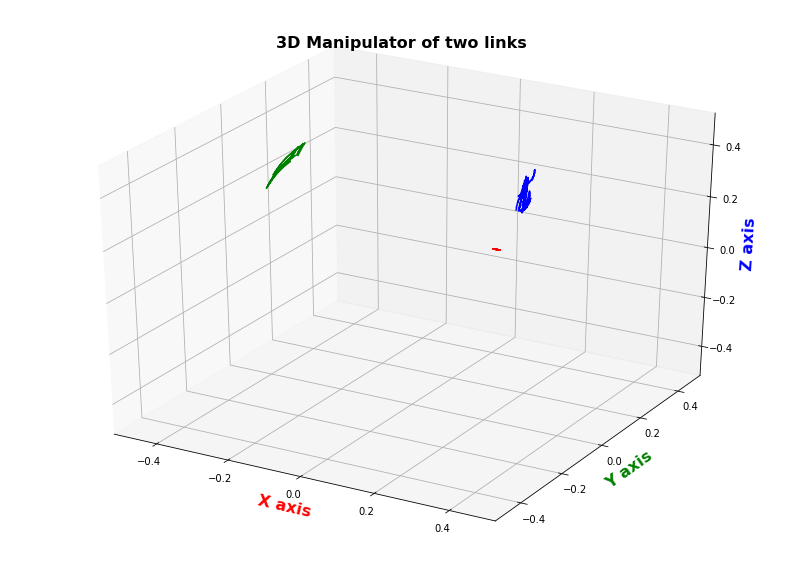

In [6]:
robot = URDF.from_xml_file('robot.urdf')
links = [rl.name for rl in robot.links]

kdl_kinT = KDLKinematics(robot,'base_link','turret_link')
kdl_kin1 = KDLKinematics(robot,'base_link','shoulder_link') #t&sh 
kdl_kin2= KDLKinematics(robot,'base_link','elbow1_link') # t&sh too
kdl_kin_ee = KDLKinematics(robot,'base_link','elbow2_link') # t,sh &elb1
#print(kdl_kin.get_joint_names())

BaseTo_turret_xyz = []
BaseTo_shoulder_xyz = []
BaseTo_elbow1_xyz = []
BaseTo_ee_xyz = []

for joint in ja_list:
    pose0 = kdl_kinT.forward(joint[:1])
    
    pose1 = kdl_kin1.forward(joint[:2])
    pose2 = kdl_kin2.forward(joint[:2])
    ee = kdl_kin_ee.forward(joint[:3])
    BaseTo_turret_xyz.append(pose0[0:3,3])
    BaseTo_shoulder_xyz.append(pose1[0:3,3])
    BaseTo_elbow1_xyz.append(pose2[0:3,3])
    BaseTo_ee_xyz.append(ee[0:3,3])
    
BaseTo_turret_XYZarray = (np.array(BaseTo_turret_xyz)).reshape(len(ja_list),3)
BaseTo_shoulder_XYZarray = (np.array(BaseTo_shoulder_xyz)).reshape(len(ja_list),3)
BaseTo_elbow1_XYZarray = (np.array(BaseTo_elbow1_xyz)).reshape(len(ja_list),3)
BaseTo_ee_XYZarray = (np.array(BaseTo_ee_xyz)).reshape(len(ja_list),3)
figure = plt.figure(figsize=(14,10),facecolor = 'w')
ax = plt.axes(projection = '3d')
ax.plot((BaseTo_turret_XYZarray[:,0]), (BaseTo_turret_XYZarray[:,1]), (BaseTo_turret_XYZarray[:,2]),c='black', label ='joints')
ax.plot((BaseTo_shoulder_XYZarray[:,0]), (BaseTo_shoulder_XYZarray[:,1]), (BaseTo_shoulder_XYZarray[:,2]),c='red', label ='joints')
ax.plot((BaseTo_elbow1_XYZarray[:,0]), (BaseTo_elbow1_XYZarray[:,1]), (BaseTo_elbow1_XYZarray[:,2]),c='green', label ='joints')
ax.plot((BaseTo_ee_XYZarray[:,0]), (BaseTo_ee_XYZarray[:,1]), (BaseTo_ee_XYZarray[:,2]),c='blue', label ='joints')

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_zlim(-0.5, 0.5)
ax.set_xlabel('X axis', fontsize=16, fontweight='bold', color='red')
ax.set_ylabel('Y axis',  fontsize=16, fontweight='bold', color='green')
ax.set_zlabel('Z axis',  fontsize=16, fontweight='bold', color='blue')
ax.set_title('3D Manipulator of two links',fontsize = 16, fontweight = 'bold')
fig = plt.show()


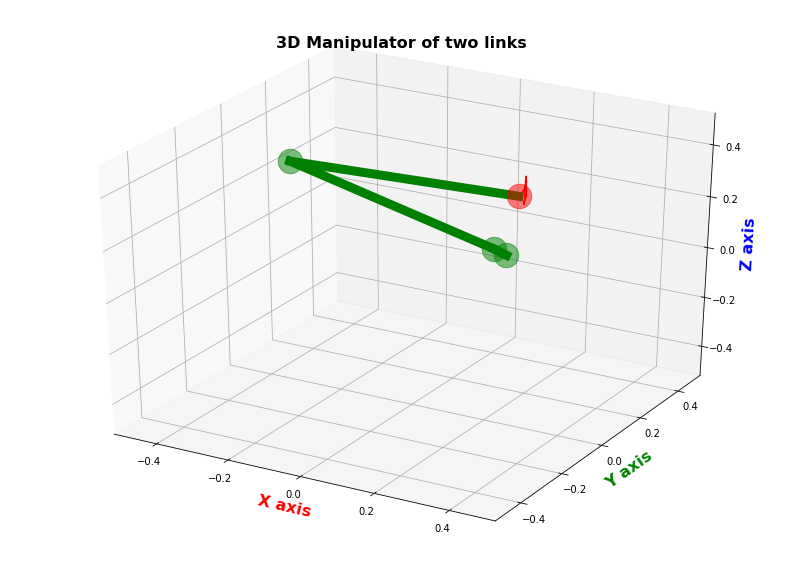

In [12]:
%matplotlib inline
import time
#import pylab as pl
from IPython import display

figure = plt.figure(figsize=(14,10),facecolor = 'w')
    
for i in range(len(BaseTo_turret_XYZarray)):
    if i%10 == 0:
        
        #pl.clf()
        ax = plt.axes(projection = '3d')
        ax.scatter3D((BaseTo_turret_XYZarray[i,0]), (BaseTo_turret_XYZarray[i,1]), (BaseTo_turret_XYZarray[i,2]),
                     c='green',s=600, label ='joints',alpha=0.5)
        ax.scatter3D((BaseTo_shoulder_XYZarray[i,0]), (BaseTo_shoulder_XYZarray[i,1]), (BaseTo_shoulder_XYZarray[i,2]),
                     c='green',s=600, label ='joints',alpha=0.5)
        ax.scatter3D((BaseTo_elbow1_XYZarray[i,0]), (BaseTo_elbow1_XYZarray[i,1]), (BaseTo_elbow1_XYZarray[i,2]),
                     c='green',s=600, label ='joints',alpha=0.5)
        ax.scatter3D((BaseTo_ee_XYZarray[i,0]), (BaseTo_ee_XYZarray[i,1]), (BaseTo_ee_XYZarray[i,2]),
                     c='red',s=600, label ='joints',alpha=0.5)
        
        ax.plot((BaseTo_ee_XYZarray[max(i-250,0):i,0]), (BaseTo_ee_XYZarray[max(i-250,0):i,1]), (BaseTo_ee_XYZarray[max(i-250,0):i,2]),
                     c='red', label ='joints')
        
        
        ax.plot3D([BaseTo_turret_XYZarray[i,0],BaseTo_shoulder_XYZarray[i,0]], 
                  [BaseTo_turret_XYZarray[i,1],BaseTo_shoulder_XYZarray[i,1]], 
                  [BaseTo_turret_XYZarray[i,2],BaseTo_shoulder_XYZarray[i,2]], 
                  'green',linewidth=9.0, label='links')
        
        ax.plot3D([BaseTo_shoulder_XYZarray[i,0],BaseTo_elbow1_XYZarray[i,0]], 
                  [BaseTo_shoulder_XYZarray[i,1],BaseTo_elbow1_XYZarray[i,1]], 
                  [BaseTo_shoulder_XYZarray[i,2],BaseTo_elbow1_XYZarray[i,2]], 
                  'green',linewidth=9.0, label='links')
        
        ax.plot3D([BaseTo_elbow1_XYZarray[i,0],BaseTo_ee_XYZarray[i,0]], 
                  [BaseTo_elbow1_XYZarray[i,1],BaseTo_ee_XYZarray[i,1]], 
                  [BaseTo_elbow1_XYZarray[i,2],BaseTo_ee_XYZarray[i,2]], 
                  'green',linewidth=9.0, label='links')
        
        ax.set_xlim(-0.5, 0.5)
        ax.set_ylim(-0.5, 0.5)
        ax.set_zlim(-0.5, 0.5)
        ax.set_xlabel('X axis', fontsize=16, fontweight='bold', color='red')
        ax.set_ylabel('Y axis',  fontsize=16, fontweight='bold', color='green')
        ax.set_zlabel('Z axis',  fontsize=16, fontweight='bold', color='blue')
        ax.set_title('3D Manipulator of two links',fontsize = 16, fontweight = 'bold')
        display.display(plt.gcf())
        display.clear_output(wait=True)
    #time.sleep(1.0)
    
    #fig = plt.show()
    

In [63]:
#plot links in stationery plot
#do UT in fk for packbot data
#plot MC & UT